# Dive into Deep Learning
# Ch 10. Modern Recurrent Neural Networks(현대적인 순환 신경망)

The first sections in this chapter will explain the LSTM architecture, a lighter-weight version called the gated recurrent unit (GRU), the key ideas behind bidirectional RNNs and a brief explanation of how RNN layers are stacked together to form deep RNNs. 

- 이 장의 첫 번째 섹션에서는 LSTM 아키텍처, 경량화된 버전인 게이트드 리커런트 유닛(GRU), 양방향 RNN의 핵심 아이디어 및 RNN 레이어가 어떻게 쌓여 깊은 RNN을 형성하는지에 대해 설명합니다.

Subsequently, we will explore the application of RNNs in sequence-to-sequence tasks, introducing machine translation along with key ideas such as encoder–decoder architectures and beam search.

- 그 후에는 RNN을 시퀀스 대 시퀀스 작업에 적용하는 방법을 탐구하며, 기계 번역을 소개하고 인코더-디코더 아키텍처와 빔 서치와 같은 주요 아이디어에 대한 간단한 설명을 제공합니다.

## Long Short-Term Memory (LSTM)

One of the first and most successful techniques for addressing vanishing gradients came in the form of the long short-term memory (LSTM) model due to Hochreiter and Schmidhuber (1997).

- 기울기 소실 문제를 해결하기 위한 최초이자 가장 성공적인 기법 중 하나는 롱 쇼트 텀 메모리 (LSTM) 모델인데, 이는 호크라이터와 슈미트후버 (1997)에 의해 제안되었습니다.

LSTMs resemble standard recurrent neural networks but here each ordinary recurrent node is replaced by a memory cell. 

- LSTM은 표준적인 순환 신경망과 유사하지만 여기서는 각 일반적인 순환 노드가 메모리 셀로 대체됩니다.

Each memory cell contains an internal state, i.e., a node with a self-connected recurrent edge of fixed weight 1, ensuring that the gradient can pass across many time steps without vanishing or exploding.

- 각 메모리 셀은 내부 상태를 포함하며, 즉, 고정된 가중치 1을 가진 자기 연결된 순환 엣지를 가진 노드가 있어 그래디언트가 사라지거나 폭발하지 않고 많은 시간 단계를 거쳐 통과할 수 있도록 합니다.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Gated Memory Cell

Each memory cell is equipped with an *internal state* and a number of multiplicative gates that determine whether (i) a given input should impact the internal state (the *input gate*), (ii) the internal state should be flushed to $0$ (the *forget gate*), and (iii) the internal state of a given neuron  should be allowed to impact the cell's output (the *output* gate). 


- 각 메모리 셀은 내부 상태와 여러 곱셈 게이트를 갖고 있는데, 이 게이트들은 (i) 주어진 입력이 내부 상태에 영향을 미쳐야 하는지를 결정하는 입력 게이트, (ii) 내부 상태를 $0$으로 플러시해야 하는지를 결정하는 망각 게이트, 그리고 (iii) 주어진 뉴런의 내부 상태가 셀의 출력에 영향을 미칠 수 있는지를 결정하는 출력 게이트가 포함됩니다.

### Gated Hidden State

The key distinction between vanilla RNNs and LSTMs is that the latter support gating of the hidden state.

- 일반 RNN과 LSTM의 주요 차이점은 후자가 은닉 상태의 게이팅을 지원한다는 것입니다.

This means that we have dedicated mechanisms for when a hidden state should be updated and also for when it should be reset. 

- 이는 은닉 상태가 언제 업데이트되어야 하는지와 언제 리셋되어야 하는지에 대한 특별한 메커니즘이 있다는 것을 의미합니다.

These mechanisms are learned and they address the concerns listed above. For instance, if the first token is of great importance we will learn not to update the hidden state after the first observation.

- 이러한 메커니즘은 학습되며, 위에서 언급한 문제를 해결합니다. 예를 들어, 첫 번째 토큰이 중요한 경우 첫 번째 관찰 후에 은닉 상태를 업데이트하지 않는 것을 학습할 것입니다.

Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed. We discuss this in detail below.

- 마찬가지로 관련 없는 임시 관찰을 건너뛰는 것을 학습할 것입니다. 마지막으로 필요할 때마다 잠재 상태를 리셋하는 방법도 학습합니다. 이에 대해 자세히 설명하겠습니다.

### Input Gate, Forget Gate, and Output Gate

The data feeding into the LSTM gates are the input at the current time step and the hidden state of the previous time step, as illustrated in Figure below.

- LSTM 게이트로 들어가는 데이터는 현재 시간 단계의 입력과 이전 시간 단계의 은닉 상태입니다. 아래 그림과 같이 설명할 수 있습니다.

Three fully connected layers with sigmoid activation functions compute the values of the input, forget, and output gates.

- 시그모이드 활성화 함수를 가진 세 개의 완전 연결 레이어가 입력, 잊어버리기 및 출력 게이트의 값을 계산합니다.

As a result of the sigmoid activation, all values of the three gates are in the range of $(0, 1)$. Additionally, we require an *input node*, typically computed with a *tanh* activation function. 

- 시그모이드 활성화로 인해 세 게이트의 모든 값은 $(0, 1)$ 범위 내에 있습니다. 또한 일반적으로 tanh 활성화 함수를 사용하여 계산하는 입력 노드가 필요합니다.

Intuitively, the *input gate* determines how much of the input node's value should be added to the current memory cell internal state.

- 직관적으로 입력 게이트는 입력 노드의 값이 현재 메모리 셀 내부 상태에 추가되어야 하는 양을 결정합니다.

The *forget gate* determines whether to keep the current value of the memory or flush it. And the *output gate* determines whether the memory cell should influence the output at the current time step. 

- 잊어버리기 게이트는 현재 메모리 값을 유지할지 삭제할지를 결정합니다. 그리고 출력 게이트는 메모리 셀이 현재 시간 단계의 출력에 영향을 미쳐야 하는지 여부를 결정합니다.

![Computing the input gate, the forget gate, and the output gate in an LSTM model.](https://d2l.ai/_images/lstm-0.svg)

Mathematically, suppose that there are $h$ hidden units, the batch size is $n$, and the number of inputs is $d$.

- 수학적으로, $h$ 개의 은닉 유닛, 배치 크기 $n$, 입력의 개수 $d$라고 가정합시다.

Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ and the hidden state of the previous time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. 

- 따라서 입력은 $\mathbf{X}t \in \mathbb{R}^{n \times d}$이며 이전 시간 단계의 은닉 상태는 $\mathbf{H}{t-1} \in \mathbb{R}^{n \times h}$입니다.

Correspondingly, the gates at time step $t$ are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. 

- 마찬가지로, 시간 단계 $t$에서의 게이트는 다음과 같이 정의됩니다. 입력 게이트는 $\mathbf{I}_t \in \mathbb{R}^{n \times h}$이며, 잊어버리기 게이트는 $\mathbf{F}_t \in \mathbb{R}^{n \times h}$이고, 출력 게이트는 $\mathbf{O}_t \in \mathbb{R}^{n \times h}$입니다.

They are calculated as follows:

- 이들은 다음과 같이 계산됩니다.

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xi}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hi}} + \mathbf{b}_\textrm{i}),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xf}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hf}} + \mathbf{b}_\textrm{f}),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xo}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{ho}} + \mathbf{b}_\textrm{o}),
\end{aligned}
$$



where $\mathbf{W}_{\textrm{xi}}, \mathbf{W}_{\textrm{xf}}, mathbf{W}_{\textrm{xo}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hi}}, \mathbf{W}_{\textrm{hf}}, \mathbf{W}_{\textrm{ho}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_\textrm{i}, \mathbf{b}_\textrm{f}, \mathbf{b}_\textrm{o} \in \mathbb{R}^{1 \times h}$ are bias parameters.

- 여기서 $\mathbf{W}{\textrm{xi}}, \mathbf{W}{\textrm{xf}}, \mathbf{W}{\textrm{xo}} \in \mathbb{R}^{d \times h}$이며 $\mathbf{W}{\textrm{hi}}, \mathbf{W}{\textrm{hf}}, \mathbf{W}{\textrm{ho}} \in \mathbb{R}^{h \times h}$는 가중치 매개변수이고, $\mathbf{b}\textrm{i}, \mathbf{b}\textrm{f}, \mathbf{b}_\textrm{o} \in \mathbb{R}^{1 \times h}$는 편향 매개변수입니다.

Note that broadcasting is triggered during the summation. We use sigmoid functions to map the input values to the interval $(0, 1)$.

- 주목할 점은 합산 중에 브로드캐스팅이 트리거되는 것입니다. 입력 값을 $(0, 1)$ 범위로 매핑하기 위해 시그모이드 함수를 사용합니다.


###  Input Node

Next we design the memory cell. Since we have not specified the action of the various gates yet, we first introduce the *input node* $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$.

- 다음으로 메모리 셀을 설계합니다. 각 게이트의 동작을 아직 지정하지 않았으므로, 우선 입력 노드 $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$를 소개합니다.

Its computation is similar to that of the three gates described above, but uses a $\tanh$ function with a value range for $(-1, 1)$ as the activation function. 

- 이 계산은 위에서 설명한 세 게이트와 유사하지만, 활성화 함수로 값 범위가 $(-1, 1)$인 $\tanh$ 함수를 사용합니다.

This leads to the following equation at time step $t$:

- 이로 인해 시간 단계 $t$에서 다음과 같은 식이 됩니다.

$$\tilde{\mathbf{C}}_t = \textrm{tanh}(\mathbf{X}_t \mathbf{W}_{\textrm{xc}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hc}} + \mathbf{b}_\textrm{c}),$$



where $\mathbf{W}_{\textrm{xc}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hc}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_\textrm{c} \in \mathbb{R}^{1 \times h}$ is a bias parameter.

- 여기서 $\mathbf{W}{\textrm{xc}} \in \mathbb{R}^{d \times h}$이고 $\mathbf{W}{\textrm{hc}} \in \mathbb{R}^{h \times h}$는 가중치 매개변수이고, $\mathbf{b}_\textrm{c} \in \mathbb{R}^{1 \times h}$는 편향 매개변수입니다.

A quick illustration of the input node is shown in figure below.

- 아래 그림에서 입력 노드의 간단한 설명을 볼 수 있습니다.

![Computing the input node in an LSTM model.](https://d2l.ai/_images/lstm-1.svg)


###  Memory Cell Internal State

In LSTMs, the input gate $\mathbf{I}_t$ governs how much we take new data into account via $\tilde{\mathbf{C}}_t$ and the forget gate $\mathbf{F}_t$ addresses how much of the old cell internal state $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain. 

- LSTM에서 입력 게이트 $\mathbf{I}_t$는 새로운 데이터를 $\tilde{\mathbf{C}}_t$를 통해 얼마나 고려할지를 조절하며, 망각 게이트 $\mathbf{F}t$는 이전 셀의 내부 상태 $\mathbf{C}{t-1} \in \mathbb{R}^{n \times h}$의 얼마를 보존할지 결정합니다.

Using the Hadamard (elementwise) product operator $\odot$ we arrive at the following update equation:

- Hadamard (원소별) 곱 연산자 $\odot$를 사용하여 다음 업데이트 식을 얻을 수 있습니다.

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$



If the forget gate is always 1 and the input gate is always 0, the memory cell internal state $\mathbf{C}_{t-1}$ will remain constant forever, passing unchanged to each subsequent time step.

- 만약 망각 게이트가 항상 1이고 입력 게이트가 항상 0이라면, 메모리 셀 내부 상태 $\mathbf{C}_{t-1}$는 영원히 일정하게 유지되어 각 이후 시간 단계로 전달됩니다.

However, input gates and forget gates give the model the flexibility of being able to learn when to keep this value unchanged and when to perturb it in response to subsequent inputs. 

- 그러나 입력 게이트와 망각 게이트는 모델이 이 값을 언제 보존하고 이후 입력에 대한 응답으로 언제 이 값을 변화시킬지를 학습할 수 있는 유연성을 제공합니다.

In practice, this design alleviates the vanishing gradient problem, resulting in models that are much easier to train, especially when facing datasets with long sequence lengths. 

- 실제로 이 설계는 사라지는 그래디언트 문제를 완화시켜, 특히 시퀀스 길이가 긴 데이터셋을 다룰 때 훨씬 쉽게 훈련할 수 있는 모델을 만들어냅니다.

We thus arrive at the flow diagram in figure below.

- 이로써 아래 그림과 같은 플로우 다이어그램을 얻게 됩니다.

![Computing the memory cell internal state in an LSTM model.](https://d2l.ai/_images/lstm-2.svg)

### Hidden State

Last, we need to define how to compute the output of the memory cell, i.e., the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$, as seen by other layers. 

- 마지막으로, 다른 층에서 볼 때 메모리 셀의 출력, 즉 숨겨진 상태 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$를 계산하는 방법을 정의해야 합니다.

This is where the output gate comes into play. In LSTMs, we first apply $\tanh$ to the memory cell internal state and then apply another point-wise multiplication, this time with the output gate.

- 여기서 출력 게이트가 작용합니다. LSTM에서는 먼저 메모리 셀의 내부 상태에 $\tanh$ 함수를 적용한 다음, 출력 게이트와 또 다른 원소별 곱셈을 적용합니다.

This ensures that the values of $\mathbf{H}_t$ are always in the interval $(-1, 1)$:

- 이를 통해 $\mathbf{H}_t$의 값이 항상 $(-1, 1)$ 구간에 있도록 보장합니다.

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$



Whenever the output gate is close to 1, we allow the memory cell internal state to impact the subsequent layers uninhibited, whereas for output gate values close to 0, we prevent the current memory from impacting other layers of the network at the current time step. 

- 출력 게이트가 1에 가까운 경우 메모리 셀의 내부 상태가 후속 층에 자유롭게 영향을 미치도록 허용하며, 출력 게이트 값이 0에 가까운 경우 현재 시간 단계의 네트워크의 다른 층에 현재 메모리가 영향을 미치는 것을 방지합니다.

Note that a memory cell can accrue information across many time steps without impacting the rest of the network (as long as the output gate takes values close to 0), and then suddenly impact the network at a subsequent time step as soon as the output gate flips from values close to 0 to values close to 1. 

- 메모리 셀은 출력 게이트가 0에 가까운 값으로 유지되는 한 많은 시간 단계 동안 정보를 축적할 수 있으며, 출력 게이트가 0에서 1로 전환될 때 다음 시간 단계에서 갑자기 네트워크에 영향을 미칠 수 있습니다.

Figure below has a graphical illustration of the data flow.

- 아래 그림은 데이터 흐름의 시각적 설명을 제공합니다.

![Computing the hidden state in an LSTM model.](https://d2l.ai/_images/lstm-3.svg)



## Implementation from Scratch

### [**Initializing Model Parameters**]

Next, we need to define and initialize the model parameters. As previously, the hyperparameter `num_hiddens` dictates the number of hidden units. We initialize weights following a Gaussian distribution with 0.01 standard deviation, and we set the biases to 0.

- 다음으로 모델 매개변수를 정의하고 초기화해야 합니다. 이전과 마찬가지로 하이퍼파라미터 num_hiddens는 은닉 유닛의 수를 결정합니다. 우리는 가중치를 0.01의 표준 편차를 가진 가우시안 분포로 초기화하고, 편향을 0으로 설정합니다.

In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        # 가중치 초기화 함수 정의
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        
        # 초기화 함수와 함께 세 개의 가중치 및 편향 행렬 생성
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        
        # 각 게이트에 대한 가중치 및 편향 행렬 생성
        self.W_xi, self.W_hi, self.b_i = triple() # 입력 게이트
        self.W_xf, self.W_hf, self.b_f = triple()  # 잊어버리는 게이트
        self.W_xo, self.W_ho, self.b_o = triple()  # 출력 게이트
        self.W_xc, self.W_hc, self.b_c = triple()  # 입력 노드

The actual model is defined as described above, consisting of three gates and an input node. Note that only the hidden state is passed to the output layer.

- 실제 모델은 위에서 설명한대로 세 개의 게이트와 입력 노드로 구성됩니다. 출력 레이어에 전달되는 것은 은닉 상태(hidden state)만입니다.

In [3]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # 초기 상태 생성: 형태 (배치 크기, 은닉 상태 크기)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        # 입력 게이트
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        # 잊어버리는 게이트
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        # 출력 게이트
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        # 셀(입력 노드) 업데이트
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        # 은닉 상태 업데이트
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

### Training and Prediction

Let’s train an LSTM model by instantiating the RNNLMScratch class.

- LSTMScratch 클래스의 인스턴스를 생성하여 LSTM 모델을 학습해보겠습니다.

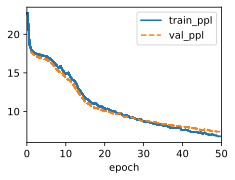

In [4]:
# 데이터 로딩
data = d2l.TimeMachine(batch_size=1024, num_steps=32)

# LSTM 모델 생성
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)

# LSTM 모델을 사용하는 RNN 언어 모델 생성
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)

# 훈련 옵션 설정
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

# 모델 훈련 시작
trainer.fit(model, data)

## Concise Implementation

Using high-level APIs, we can directly instantiate an LSTM model. This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out before.

- 고수준 API를 사용하면 LSTM 모델을 직접 인스턴스화할 수 있습니다. 이는 위에서 명시적으로 설정한 모든 구성 세부 정보를 캡슐화합니다. 이 코드는 이전에 우리가 상세히 설명한 많은 세부 정보에 대해 파이썬 대신 컴파일된 연산자를 사용하기 때문에 훨씬 빠릅니다.

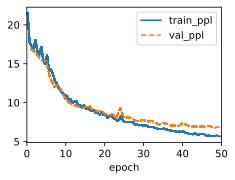

In [5]:
# LSTM 모델 정의
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        # nn.LSTM을 사용하여 LSTM 레이어 정의
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

# LSTM 모델 인스턴스 생성
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)

# LSTM을 사용하는 RNN 언어 모델 생성
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)

# 모델 훈련 시작
trainer.fit(model, data)

In [6]:
# 훈련된 모델로부터 문장 예측
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has i the traveller the'

LSTMs are the prototypical latent variable autoregressive model with nontrivial state control. Many variants thereof have been proposed over the years, e.g., multiple layers, residual connections, different types of regularization. 

- LSTM은 비자명 상태 변수 자기회귀 모델로서 중요한 상태 제어를 갖는 원형입니다. 여러 변형이 오랜 기간 동안 제안되어왔으며, 예를 들어 여러 개의 레이어, 잔차 연결, 다양한 유형의 정규화 등이 있습니다.

However, training LSTMs and other sequence models (such as GRUs) is quite costly because of the long range dependency of the sequence. Later we will encounter alternative models such as Transformers that can be used in some cases.

- 그러나 LSTMs와 같은 시퀀스 모델(예: GRUs)을 훈련하는 것은 시퀀스의 장거리 종속성으로 인해 상당히 비용이 많이 듭니다. 나중에 우리는 이와 관련하여 어떤 경우에 사용될 수 있는 Transformer와 같은 대체 모델들을 다룰 것입니다.


## Gated Recurrent Units (GRU)

As RNNs and particularly the LSTM architecture rapidly gained popularity during the 2010s, a number of researchers began to experiment with simplified architectures in hopes of retaining the key idea of incorporating an internal state and multiplicative gating mechanisms but with the aim of speeding up computation. 

- 2010년대 동안 RNN과 특히 LSTM 아키텍처가 급속하게 인기를 얻자, 일부 연구자들은 내부 상태와 곱셈 게이팅 메커니즘을 포함하는 핵심 아이디어를 유지하면서 계산 속도를 높이기 위해 단순화된 아키텍처를 실험하기 시작했습니다.

The gated recurrent unit (GRU) (Cho et al., 2014) offered a streamlined version of the LSTM memory cell that often achieves comparable performance but with the advantage of being faster to compute (Chung et al., 2014).

- 게이트드 리커런트 유닛(GRU) (Cho et al., 2014)은 종종 동등한 성능을 달성하지만 계산이 더 빠른 장점을 가진 LSTM 메모리 셀의 간소화된 버전을 제공했습니다 (Chung et al., 2014).

### Reset Gate and Update Gate

Here, the LSTM's three gates are replaced by two: the *reset gate* and the *update gate*. As with LSTMs, these gates are given sigmoid activations, forcing their values to lie in the interval $(0, 1)$. 

- 여기서 LSTM의 세 가지 게이트는 두 가지로 대체됩니다: 리셋 게이트와 업데이트 게이트. LSTMs와 마찬가지로 이러한 게이트들은 시그모이드 활성화 함수가 부여되어 값을 구간 $(0, 1)$ 내로 강제합니다.

Intuitively, the reset gate controls how much of the previous state we might still want to remember. Likewise, an update gate would allow us to control how much of the new state is just a copy of the old one.

- 직관적으로, 리셋 게이트는 이전 상태의 얼마나 많은 부분을 여전히 기억하길 원하는지를 제어합니다. 마찬가지로, 업데이트 게이트는 새로운 상태의 얼마나 많은 부분이 이전 상태의 복사본인지를 제어할 수 있게 합니다.

Figure below illustrates the inputs for both the reset and update gates in a GRU, given the input of the current time step and the hidden state of the previous time step. The outputs of the gates are given by two fully connected layers with a sigmoid activation function.

- 아래 그림은 GRU의 리셋 게이트와 업데이트 게이트의 입력을 나타내며, 현재 시간 단계의 입력과 이전 시간 단계의 숨겨진 상태가 주어졌을 때입니다. 게이트의 출력은 시그모이드 활성화 함수를 가진 두 개의 완전 연결 레이어로부터 나옵니다.

![Computing the reset gate and the update gate in a GRU model.](https://d2l.ai/_images/gru-1.svg)


Mathematically, for a given time step $t$, suppose that the input is a minibatch $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples $=n$; number of inputs $=d$) and the hidden state of the previous time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden units $=h$). 

- 수학적으로, 주어진 시간 단계 $t$에 대해 입력이 미니배치 $\mathbf{X}t \in \mathbb{R}^{n \times d}$ (예제 수 $=n$; 입력 수 $=d$)이고 이전 시간 단계의 숨겨진 상태는 $\mathbf{H}{t-1} \in \mathbb{R}^{n \times h}$ (숨겨진 유닛 수 $=h$)라고 가정합니다.

Then the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

- 그런 다음 리셋 게이트 $\mathbf{R}_t \in \mathbb{R}^{n \times h}$와 업데이트 게이트 $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$는 다음과 같이 계산됩니다:


$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xr}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hr}} + \mathbf{b}_\textrm{r}),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xz}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hz}} + \mathbf{b}_\textrm{z}),
\end{aligned}
$$

where $\mathbf{W}_{\textrm{xr}}, \mathbf{W}_{\textrm{xz}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hr}}, \mathbf{W}_{\textrm{hz}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_\textrm{r}, \mathbf{b}_\textrm{z} \in \mathbb{R}^{1 \times h}$ are bias parameters.

- 여기서 $\mathbf{W}{\textrm{xr}}, \mathbf{W}{\textrm{xz}} \in \mathbb{R}^{d \times h}$ 및 $\mathbf{W}{\textrm{hr}}, \mathbf{W}{\textrm{hz}} \in \mathbb{R}^{h \times h}$는 가중치 매개변수이며 $\mathbf{b}\textrm{r}, \mathbf{b}\textrm{z} \in \mathbb{R}^{1 \times h}$는 편향 매개변수입니다.

### Candidate Hidden State

Next, we integrate the reset gate $\mathbf{R}_t$ with the regular updating mechanism,leading to the following *candidate hidden state* $\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step $t$:

- 다음으로, 우리는 리셋 게이트 $\mathbf{R}_t$를 일반적인 업데이트 메커니즘과 통합하여 시간 단계 $t$에서의 후보 은닉 상태 $\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$를 다음과 같이 얻습니다:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\textrm{hh}} + \mathbf{b}_\textrm{h}),$$

where $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$ are weight parameters, $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$ is the bias, and the symbol $\odot$ is the Hadamard (elementwise) product operator.

- 여기서 $\mathbf{W}{\textrm{xh}} \in \mathbb{R}^{d \times h}$와 $\mathbf{W}{\textrm{hh}} \in \mathbb{R}^{h \times h}$는 가중치 매개변수이며, $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$는 편향입니다. 기호 $\odot$는 Hadamard (원소별) 곱 연산자입니다.

Here we use a tanh activation function.

- 여기서는 tanh 활성화 함수를 사용합니다.



The result is a *candidate*, since we still need to incorporate the action of the update gate. Comparing with, the influence of the previous states can now be reduced with the elementwise multiplication of $\mathbf{R}_t$ and $\mathbf{H}_{t-1}$ in Figure below.

- 업데이트 게이트의 작업을 통합해야 하므로 결과는 *후보*입니다. 비교하면, 이제 아래 그림에서 $\mathbf{R}_t$와 $\mathbf{H}_{t-1}$의 요소별 곱셈을 통해 이전 상태의 영향을 줄일 수 있습니다.

Whenever the entries in the reset gate $\mathbf{R}_t$ are close to 1, we recover a vanilla RNN such as that in :eqref:`rnn_h_with_state`. For all entries of the reset gate $\mathbf{R}_t$ that are close to 0, the candidate hidden state is the result of an MLP with $\mathbf{X}_t$ as input. Any pre-existing hidden state is thus *reset* to defaults.

- 재설정 게이트 $\mathbf{R}_t$의 항목이 1에 가까울 때마다 :eqref:`rnn_h_with_state`와 같은 바닐라 RNN을 복구합니다. 0에 가까운 재설정 게이트 $\mathbf{R}_t$의 모든 항목에 대해 후보 숨겨진 상태는 $\mathbf{X}_t$를 입력으로 사용하는 MLP의 결과입니다. 따라서 기존의 모든 숨겨진 상태는 기본값으로 *재설정*됩니다.


Figure below illustrates the computational flow after applying the reset gate.

- 아래 그림은 리셋 게이트를 적용한 후의 계산 흐름을 보여줍니다.

![Computing the candidate hidden state in a GRU model.](https://d2l.ai/_images/gru-2.svg)

###  Hidden State

Finally, we need to incorporate the effect of the update gate $\mathbf{Z}_t$. This determines the extent to which the new hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ matches the old state $\mathbf{H}_{t-1}$ compared with how much it resembles the new candidate state $\tilde{\mathbf{H}}_t$.

- 마지막으로 업데이트 게이트 $\mathbf{Z}_t$의 효과를 통합해야 합니다. 이는 새로운 숨겨진 상태 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$가 비교된 이전 상태 $\mathbf{H}_{t-1}$와 일치하는 정도를 결정합니다. 새로운 후보 상태 $\tilde{\mathbf{H}}_t$와 얼마나 유사한지 확인하세요.

The update gate $\mathbf{Z}_t$ can be used for this purpose, simply by taking elementwise convex combinations of $\mathbf{H}_{t-1}$ and $\tilde{\mathbf{H}}_t$. This leads to the final update equation for the GRU:

- 업데이트 게이트 $\mathbf{Z}_t$는 $\mathbf{H}_{t-1}$ 및 $\tilde{\mathbf{H}}_t의 요소별 볼록 조합을 사용하여 이 목적으로 사용할 수 있습니다. $. 이는 GRU의 최종 업데이트 방정식으로 이어집니다.

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$



Whenever the update gate $\mathbf{Z}_t$ is close to 1, we simply retain the old state. In this case the information from $\mathbf{X}_t$ is ignored, effectively skipping time step $t$ in the dependency chain. 

- 업데이트 게이트 $\mathbf{Z}_t$가 1에 가까울 때마다 우리는 단순히 이전 상태를 유지합니다. 이 경우 $\mathbf{X}_t$의 정보는 무시되어 종속성 체인에서 $t$ 시간 단계를 효과적으로 건너뜁니다.

By contrast, whenever $\mathbf{Z}_t$ is close to 0, the new latent state $\mathbf{H}_t$ approaches the candidate latent state $\tilde{\mathbf{H}}_t$. 

- 대조적으로, $\mathbf{Z}_t$가 0에 가까울 때마다 새로운 잠재 상태 $\mathbf{H}_t$는 후보 잠재 상태 $\tilde{\mathbf{H}}_t$에 접근합니다.

Figure below shows the computational flow after the update gate is in action.

- 아래 그림은 업데이트 게이트가 작동된 후의 계산 흐름을 보여줍니다.

![Computing the hidden state in a GRU model.](https://d2l.ai/_images/gru-3.svg)


In summary, GRUs have the following two distinguishing features:

요약하면 GRU에는 다음과 같은 두 가지 구별되는 기능이 있습니다.


1. Reset gates help capture short-term dependencies in sequences.

    - 재설정 게이트는 시퀀스의 단기 종속성을 캡처하는 데 도움이 됩니다.

2. Update gates help capture long-term dependencies in sequences.

    - 업데이트 게이트는 시퀀스의 장기적인 종속성을 캡처하는 데 도움이 됩니다.

## Implementation from Scratch

To gain a better understanding of the GRU model, let's implement it from scratch.

### Initializing Model Parameters (모델 매개변수 초기화)

The first step is to initialize the model parameters. We draw the weights from a Gaussian distribution with standard deviation to be `sigma` and set the bias to 0. The hyperparameter `num_hiddens` defines the number of hidden units.

- 첫 번째 단계는 모델 매개변수를 초기화하는 것입니다. 표준편차가 '시그마'인 가우스 분포에서 가중치를 도출하고 편향을 0으로 설정합니다. 하이퍼파라미터 'num_hiddens'는 숨겨진 단위의 수를 정의합니다.

We instantiate all weights and biases relating to the update gate, the reset gate, and the candidate hidden state.

- 첫 번째 단계는 모델 매개변수를 초기화하는 것입니다. 표준편차가 '시그마'인 가우스 분포에서 가중치를 도출하고 편향을 0으로 설정합니다. 하이퍼파라미터 'num_hiddens'는 숨겨진 단위의 수를 정의합니다.

In [7]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        # 가중치 초기화 함수 정의
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        
        # 초기화 함수와 함께 세 개의 가중치 및 편향 행렬 생성
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        
        # 업데이트 게이트에 대한 가중치와 편향 행렬 생성
        self.W_xz, self.W_hz, self.b_z = triple()  # 업데이트 게이트
        # 리셋 게이트에 대한 가중치와 편향 행렬 생성
        self.W_xr, self.W_hr, self.b_r = triple()  # 리셋 게이트
        # 후보 은닉 상태에 대한 가중치와 편향 행렬 생성
        self.W_xh, self.W_hh, self.b_h = triple()  # 후보 은닉 상태

### Defining the Model (모델 정의)

Now we are ready to define the GRU forward computation. Its structure is the same as that of the basic RNN cell, except that the update equations are more complex.

- 이제 GRU 순방향 계산을 정의할 준비가 되었습니다. 그 구조는 업데이트 방정식이 더 복잡하다는 점을 제외하면 기본 RNN 셀의 구조와 동일합니다.

In [8]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # 초기 상태 생성: 형태 (배치 크기, 은닉 상태 크기)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    outputs = []
    for X in inputs:
        # 업데이트 게이트 계산
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
        # 리셋 게이트 계산
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        # 후보 은닉 상태 계산
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        # 새로운 은닉 상태 업데이트
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

### Training

Training a language model on The Time Machine dataset works in exactly the same manner as in :numref:sec_rnn-scratch.

- Time Machine 데이터 세트에서 언어 모델을 훈련하는 것은 :numref:sec_rnn-scratch와 정확히 동일한 방식으로 작동합니다.

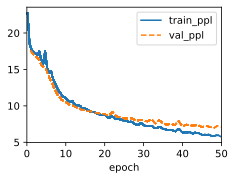

In [9]:
# 데이터 로딩
data = d2l.TimeMachine(batch_size=1024, num_steps=32)

# GRU 모델 생성
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)

# GRU 모델을 사용하는 RNN 언어 모델 생성
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)

# 훈련 옵션 설정
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

# 모델 훈련 시작
trainer.fit(model, data)

## Concise Implementation

In high-level APIs, we can directly instantiate a GRU model. This encapsulates all the configuration detail that we made explicit above.

- 고급 API에서는 GRU 모델을 직접 인스턴스화할 수 있습니다. 이는 위에서 명시한 모든 구성 세부 사항을 캡슐화합니다.

In [10]:
# GRU 모델 정의
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        # nn.GRU를 사용하여 GRU 레이어 정의
        self.rnn = nn.GRU(num_inputs, num_hiddens)

The code is significantly faster in training as it uses compiled operators rather than Python.

- 코드는 Python 대신 컴파일된 연산자를 사용하므로 학습 속도가 훨씬 빠릅니다.

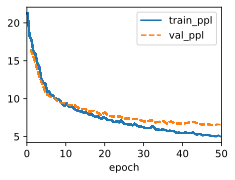

In [11]:
# GRU 모델 인스턴스 생성
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)

# GRU를 사용하는 RNN 언어 모델 생성
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)

# 모델 훈련 시작
trainer.fit(model, data)

After training, we print out the perplexity on the training set and the predicted sequence following the provided prefix.

- 훈련 후에는 훈련 세트의 난해함과 제공된 접두사 다음에 나오는 예측 시퀀스를 인쇄합니다.

In [12]:
# 훈련된 모델로부터 문장 예측
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has in a mone at a mone'

# Deep Recurrent Neural Networks (심층 순환 신경망)

We often construct RNNs that are deep not only in the time direction but also in the input-to-output direction. This is precisely the notion of depth that we have already encountered in our development of MLPs and deep CNNs.

- 우리는 시간 방향뿐만 아니라 입력-출력 방향에서도 깊은 RNN을 구성하는 경우가 많습니다. 이것이 바로 우리가 MLP 및 심층 CNN 개발에서 이미 접한 깊이의 개념입니다.

The standard method for building this sort of deep RNN is strikingly simple: we stack the RNNs on top of each other. Given a sequence of length $T$, the first RNN produces a sequence of outputs, also of length $T$.

- 이러한 종류의 심층 RNN을 구축하는 표준 방법은 매우 간단합니다. RNN을 서로 쌓습니다. 길이가 $T$인 시퀀스가 주어지면 첫 번째 RNN은 역시 길이가 $T$인 출력 시퀀스를 생성합니다.

These, in turn, constitute the inputs to the next RNN layer. In this short section, we illustrate this design pattern and present a simple example for how to code up such stacked RNNs.

- 이는 차례로 다음 RNN 레이어에 대한 입력을 구성합니다. 이 짧은 섹션에서는 이 디자인 패턴을 설명하고 이러한 스택 RNN을 코딩하는 방법에 대한 간단한 예를 제시합니다.

Figure below, we illustrate a deep RNN with $L$ hidden layers. Each hidden state operates on a sequential input and produces a sequential output.

- 아래 그림에서는 $L$ 숨겨진 레이어가 있는 심층 RNN을 보여줍니다. 각 숨겨진 상태는 순차적 입력에 대해 작동하고 순차적 출력을 생성합니다.

Moreover, any RNN cell (white box in figure below) at each time step depends on both the same layer's value at the previous time step and the previous layer's value at the same time step. 

- 또한 각 시간 단계의 RNN 셀(아래 그림의 흰색 상자)은 이전 시간 단계의 동일한 레이어 값과 동일한 시간 단계의 이전 레이어 값에 따라 달라집니다.

![Architecture of a deep RNN.](https://d2l.ai/_images/deep-rnn.svg)

## Implementation from Scratch

To implement a multilayer RNN from scratch, we can treat each layer as an RNNScratch instance with its own learnable parameters.

- RNNScratch다층 RNN을 처음부터 구현하기 위해 각 계층을 자체 학습 가능한 매개변수가 있는 인스턴스 로 처리할 수 있습니다 .


In [13]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # 여러 개의 층으로 구성된 RNN을 정의합니다.
        self.rnns = nn.Sequential(*[d2l.RNNScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])

The multilayer forward computation simply performs forward computation layer by layer.

- 다층 순방향 계산은 단순히 계층별로 순방향 계산을 수행합니다.

In [14]:
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None:
        # 초기 은닉 상태 리스트 생성: 층별로 (배치 크기, 은닉 상태 크기) 형태의 텐서
        Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        # i번째 층의 RNN 계산 수행
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = torch.stack(outputs, 0)  # 텐서를 쌓아서 시간 차원 추가
    return outputs, Hs

As an example, we train a deep GRU model on The Time Machine dataset (same as in Section 9.5). To keep things simple we set the number of layers to 2.

- 예를 들어, Time Machine 데이터세트에 대한 심층적인 GRU 모델을 훈련합니다( 섹션 9.5 와 동일 ). 작업을 단순하게 유지하기 위해 레이어 수를 2로 설정했습니다.

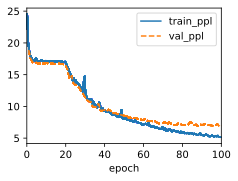

In [15]:
# 데이터 로딩
data = d2l.TimeMachine(batch_size=1024, num_steps=32)

# 여러 개의 층으로 구성된 RNN 블록 생성
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)

# RNN 블록을 사용하는 RNN 언어 모델 생성
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)

# 훈련 옵션 설정
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)

# 모델 훈련 시작
trainer.fit(model, data)

### Concise Implementation ( 간결한 구현 )

Fortunately many of the logistical details required to implement multiple layers of an RNN are readily available in high-level APIs. Our concise implementation will use such built-in functionalities. 

- 다행스럽게도 RNN의 여러 계층을 구현하는 데 필요한 많은 세부 사항을 상위 수준 API에서 쉽게 사용할 수 있습니다. 우리의 간결한 구현에서는 이러한 내장 기능을 사용합니다.

The code generalizes the one we used previously in Section, letting us specify the number of layers explicitly rather than picking the default of only one layer.

- 코드는 이전 섹션에서 사용한 코드를 일반화하여 단 하나의 레이어에 대한 기본값을 선택하는 대신 명시적으로 레이어 수를 지정할 수 있도록 합니다.


In [16]:
class GRU(d2l.RNN):  #@save
    """다층 GRU 모델입니다."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        # nn.GRU를 사용하여 다층 GRU 레이어를 정의합니다.
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

The architectural decisions such as choosing hyperparameters are very similar to those of before Section. We pick the same number of inputs and outputs as we have distinct tokens, i.e., vocab_size. 

- 하이퍼파라미터 선택과 같은 아키텍처 결정은 이전 섹션과 매우 유사합니다. 우리는 별도의 토큰(예: vocab_size)이 있으므로 동일한 수의 입력 및 출력을 선택합니다.

The number of hidden units is still 32. The only difference is that we now select a nontrivial number of hidden layers by specifying the value of num_layers.

- 숨겨진 단위의 수는 여전히 32개입니다. 유일한 차이점은 이제 num_layers 값을 지정하여 적지 않은 수의 숨겨진 레이어를 선택한다는 것입니다.

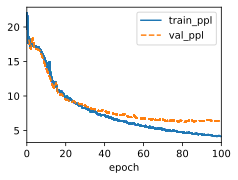

In [17]:
# 다층 GRU 모델 인스턴스 생성
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)

# 다층 GRU를 사용하는 RNN 언어 모델 생성
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)

# 모델 훈련 시작
trainer.fit(model, data)

In [18]:
# 훈련된 모델로부터 문장 예측
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has it a man the this t'

# Bidirectional Recurrent Neural Networks (양방향 순환 신경망)

Another common task—often useful as a pretraining exercise prior to fine-tuning a model on an actual task of interest—is to mask out random tokens in a text document and then to train a sequence model to predict the values of the missing tokens.

- 관심 있는 실제 작업에 대한 모델을 미세 조정하기 전에 사전 훈련 연습으로 유용한 또 다른 일반적인 작업은 텍스트 문서에서 임의의 토큰을 마스크한 다음 시퀀스 모델을 훈련하여 누락된 토큰의 값을 예측하는 것입니다.

Note that depending on what comes after the blank, the likely value of the missing token changes dramatically:

- 공백 뒤에 오는 내용에 따라 누락된 토큰의 예상 값이 크게 변경됩니다.

I am ___.

I am ___ hungry.

I am ___ hungry, and I can eat half a pig.

In the first sentence “happy” seems to be a likely candidate. The words “not” and “very” seem plausible in the second sentence, but “not” seems incompatible with the third sentences.

- 첫 번째 문장에서는 "행복하다"가 유력한 후보인 것 같습니다. 두 번째 문장에서는 "not"과 "very"라는 단어가 그럴듯해 보이지만, "not"은 세 번째 문장과 호환되지 않는 것 같습니다.

Fortunately, a simple technique transforms any unidirectional RNN into a bidirectional RNN :cite:`Schuster.Paliwal.1997`.

- 다행히 간단한 기술을 사용하면 모든 단방향 RNN을 양방향 RNN :cite:`Schuster.Paliwal.1997`로 변환할 수 있습니다.

We simply implement two unidirectional RNN layers chained together in opposite directions  and acting on the same input (figure below).

- 우리는 서로 반대 방향으로 연결되고 동일한 입력에 대해 작동하는 두 개의 단방향 RNN 레이어를 구현합니다(아래 그림).

For the first RNN layer, the first input is $\mathbf{x}_1$ and the last input is $\mathbf{x}_T$, but for the second RNN layer, the first input is $\mathbf{x}_T$ and the last input is $\mathbf{x}_1$.

- 첫 번째 RNN 레이어의 경우 첫 번째 입력은 $\mathbf{x}_1$이고 마지막 입력은 $\mathbf{x}_T$이지만 두 번째 RNN 레이어의 경우 첫 번째 입력은 $\mathbf{x}_T입니다. $이고 마지막 입력은 $\mathbf{x}_1$입니다.

To produce the output of this bidirectional RNN layer, we simply concatenate together the corresponding outputs of the two underlying unidirectional RNN layers. 

- 이 양방향 RNN 레이어의 출력을 생성하려면 두 개의 기본 단방향 RNN 레이어의 해당 출력을 연결하기만 하면 됩니다.

![Architecture of a bidirectional RNN.](https://d2l.ai/_images/birnn.svg)

## Implementation from Scratch

To implement a bidirectional RNN from scratch, we can include two unidirectional RNNScratch instances with separate learnable parameters.

- 양방향 RNN을 처음부터 구현하려면 RNNScratch별도의 학습 가능한 매개변수가 있는 두 개의 단방향 인스턴스를 포함할 수 있습니다.

In [19]:
class BiRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # Forward RNN과 Backward RNN을 생성합니다.
        self.f_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        # 출력 차원을 두 배로 증가시킵니다.
        self.num_hiddens *= 2  # 출력 차원이 두 배로 증가합니다.

States of forward and backward RNNs are updated separately, while outputs of these two RNNs are concatenated.

- 정방향 및 역방향 RNN의 상태는 별도로 업데이트되는 반면, 이 두 RNN의 출력은 연결됩니다.

In [20]:
@d2l.add_to_class(BiRNNScratch)
def forward(self, inputs, Hs=None):
    f_H, b_H = Hs if Hs is not None else (None, None)
    # Forward RNN과 Backward RNN을 순전파합니다.
    f_outputs, f_H = self.f_rnn(inputs, f_H)
    b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
    # 양방향 RNN의 출력을 결합하여 양방향 특성을 생성합니다.
    outputs = [torch.cat((f, b), -1) for f, b in zip(
        f_outputs, reversed(b_outputs))]
    return outputs, (f_H, b_H)

## Concise Implementation

Using the high-level APIs, we can implement bidirectional RNNs more concisely. Here we take a GRU model as an example.

- 고급 API를 사용하면 양방향 RNN을 보다 간결하게 구현할 수 있습니다. 여기서는 GRU 모델을 예로 들어보겠습니다.



In [21]:
class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        # bidirectional=True로 설정하여 양방향 GRU를 생성합니다.
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        # 출력 차원을 두 배로 증가시킵니다.
        self.num_hiddens *= 2

# Machine Translation and the Dataset (기계 번역 및 데이터 세트)

In this section, we introduce the machine translation problem and an example dataset that we will use in the subsequent examples. 

- 이 섹션에서는 기계 번역 문제와 후속 예제에서 사용할 예제 데이터세트를 소개합니다. 

For decades, statistical formulations of translation between languages had been popular (Brown et al., 1990, Brown et al., 1988), even before researchers got neural network approaches working (methods were often lumped together under the term neural machine translation).

 - 수십 년 동안, 언어 간 번역의 통계적 공식화 는 연구자들이 신경망 접근 방식을 사용하기 전에도 인기가 있었습니다 ( Brown et al. , 1990 , Brown et al. , 1988 ) . (방법은 종종 신경 기계 번역 이라는 용어로 함께 묶였습니다 .)
 
The following code snippets will show how to load the preprocessed data into minibatches for training.

- 다음 코드 조각은 훈련을 위해 전처리된 데이터를 미니배치에 로드하는 방법을 보여줍니다.

## Downloading and Preprocessing the Dataset

To begin, we download an English–French dataset that consists of bilingual sentence pairs from the Tatoeba Project.

- 시작하려면 Tatoeba 프로젝트의 이중 언어 문장 쌍 으로 구성된 영어-프랑스어 데이터세트를 다운로드합니다 .

Each line in the dataset is a tab-delimited pair consisting of an English text sequence (the source) and the translated French text sequence (the target). 

- 데이터세트의 각 줄은 탭으로 구분된 쌍으로, 영어 텍스트 시퀀스( source ) 와 번역된 프랑스어 텍스트 시퀀스( target ) 로 구성됩니다.

Note that each text sequence can be just one sentence, or a paragraph of multiple sentences.

- 각 텍스트 시퀀스는 한 문장일 수도 있고 여러 문장으로 구성된 단락일 수도 있습니다.

In [22]:
import os

class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        # 데이터 다운로드 및 압축 해제
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        # 다운로드한 데이터 파일(fra.txt) 열어서 내용 읽기
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

# MTFraEng 데이터 모듈 인스턴스 생성
data = MTFraEng()

# 데이터 다운로드 및 내용 출력
raw_text = data._download()
print(raw_text[:75])  # 데이터의 처음 75글자 출력

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



After downloading the dataset, we proceed with several preprocessing steps for the raw text data. For instance, we replace non-breaking space with space, convert uppercase letters to lowercase ones, and insert space between words and punctuation marks.

- 데이터 세트를 다운로드한 후 원시 텍스트 데이터에 대한 여러 전처리 단계를 진행합니다. 예를 들어, 줄 바꿈하지 않는 공백을 공백으로 바꾸고, 대문자를 소문자로 변환하고, 단어와 구두점 사이에 공백을 삽입합니다.

In [23]:
@d2l.add_to_class(MTFraEng)  #@save
def _preprocess(self, text):
    # 공백이 아닌 공간을 공백으로 대체합니다.
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # 단어와 구두점 사이에 공백을 삽입합니다.
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

# 전처리된 데이터 출력
text = data._preprocess(raw_text)
print(text[:80])  # 전처리된 데이터의 처음 80글자 출력

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


##  Tokenization

The following `_tokenize` method tokenizes the first `max_examples` text sequence pairs, where each token is either a word or a punctuation mark.

- 아래의 _tokenize 메서드는 첫 max_examples 개의 텍스트 시퀀스 쌍을 토큰화합니다. 각 토큰은 단어 또는 구두점 기호일 수 있습니다.

We append the special “&lt;eos&gt;” token to the end of every sequence to indicate the end of the sequence.

- 우리는 각 시퀀스의 끝을 나타내기 위해 특별한 "<eos>" 토큰을 시퀀스 끝에 추가합니다.

When a model is predicting by generating a sequence token after token, the generation of the “&lt;eos&gt;” token can suggest that the output sequence is complete.

- 모델이 토큰 단위로 시퀀스를 생성하여 예측할 때, "e<eos>" 토큰의 생성은 출력 시퀀스가 완료되었음을 나타낼 수 있습니다.

In the end, the method below returns two lists of token lists: `src` and `tgt`.

- 최종적으로 아래의 메서드는 두 개의 토큰 리스트 목록을 반환합니다: src와 tgt.

Specifically, `src[i]` is a list of tokens from the $i^\textrm{th}$ text sequence in the source language (English here) and `tgt[i]` is that in the target language (French here).

- 구체적으로, src[i]는 소스 언어 (영어)의 $i^\textrm{번째}$ 텍스트 시퀀스의 토큰 목록이고, tgt[i]는 대상 언어 (프랑스어)의 해당 텍스트 시퀀스의 토큰 목록입니다.

In [24]:
@d2l.add_to_class(MTFraEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # 빈 토큰은 건너뜁니다.
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

# 데이터 토큰화
src, tgt = data._tokenize(text)

# 토큰화된 데이터의 처음 6개 문장 출력
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>']])

Let’s plot the histogram of the number of tokens per text sequence. In this simple English–French dataset, most of the text sequences have fewer than 20 tokens.

- 텍스트 시퀀스당 토큰 수의 히스토그램을 그려 보겠습니다. 이 간단한 영어-프랑스어 데이터 세트에서 대부분의 텍스트 시퀀스에는 20개 미만의 토큰이 있습니다.

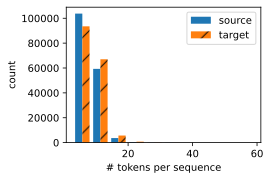

In [25]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """두 개의 리스트의 길이에 대한 히스토그램을 그립니다."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

# 소스 문장과 대상 문장의 길이에 대한 히스토그램 그리기
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src, tgt);

## Loading Sequences of Fixed Length ( 고정 길이의 로딩 시퀀스)

Recall that in language modeling each example sequence, either a segment of one sentence or a span over multiple sentences, had a fixed length.

- 언어 모델링에서 각 예제 시퀀스(한 문장의 세그먼트 또는 여러 문장에 대한 범위)는 고정된 길이를 가졌습니다. 

In machine translation, each example is a pair of source and target text sequences, where the two text sequences may have different lengths.

-기계 번역에서 각 예는 소스 및 대상 텍스트 시퀀스의 쌍이며 두 텍스트 시퀀스의 길이는 다를 수 있습니다.

For computational efficiency, we can still process a minibatch of text sequences at one time by truncation and padding. Suppose that every sequence in the same minibatch should have the same length num_steps.

- 계산 효율성을 위해 잘라내기 및 채우기를 통해 한 번에 텍스트 시퀀스의 미니배치를 처리할 수 있습니다. 동일한 미니배치의 모든 시퀀스의 길이는 num_steps와 같아야 한다고 가정합니다.

If a text sequence has fewer than num_steps tokens, we will keep appending the special “<pad>” token to its end until its length reaches num_steps. Otherwise, we will truncate the text sequence by only taking its first num_steps tokens and discarding the remaining. 
    
- 텍스트 시퀀스의 토큰이 num_steps보다 적으면 길이가 num_steps에 도달할 때까지 특수 "<pad>" 토큰을 끝에 계속 추가합니다. 그렇지 않으면 첫 번째 num_steps 토큰만 취하고 나머지는 삭제하여 텍스트 시퀀스를 자릅니다.

In this way, every text sequence will have the same length to be loaded in minibatches of the same shape. Furthermore, we also record length of the source sequence excluding padding tokens.

- 이러한 방식으로 모든 텍스트 시퀀스는 동일한 모양의 미니 배치에 로드될 수 있는 동일한 길이를 갖게 됩니다. 또한 패딩 토큰을 제외한 소스 시퀀스의 길이도 기록합니다.

Since the machine translation dataset consists of pairs of languages, we can build two vocabularies for both the source language and the target language separately.
    
- 기계 번역 데이터 세트는 언어 쌍으로 구성되므로 소스 언어와 대상 언어 모두에 대해 별도로 두 개의 어휘를 구축할 수 있습니다.
    
With word-level tokenization, the vocabulary size will be significantly larger than that using character-level tokenization. 
    
- 단어 수준 토큰화를 사용하면 문자 수준 토큰화를 사용하는 것보다 어휘 크기가 훨씬 커집니다.

In [26]:
@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())

@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

 ## Reading the Dataset
 
Finally, we define the get_dataloader method to return the data iterator.

- get_dataloader마지막으로 데이터 반복자를 반환하는 메서드를 정의합니다 .

In [27]:
@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

Let’s read the first minibatch from the English–French dataset.

- 영어-프랑스어 데이터세트의 첫 번째 미니배치를 읽어보겠습니다.

In [28]:
data = MTFraEng(batch_size=3)  # 배치 크기가 3인 데이터 모듈 생성
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))  # 첫 번째 배치 데이터 가져오기

print('source:', src.type(torch.int32))  # 소스 데이터 출력 (int32 타입)
print('decoder input:', tgt.type(torch.int32))  # 디코더 입력 데이터 출력 (int32 타입)
print('source len excluding pad:', src_valid_len.type(torch.int32))  # 패딩 제외한 소스 문장 길이 출력 (int32 타입)
print('label:', label.type(torch.int32))  # 레이블 데이터 출력 (int32 타입)

source: tensor([[ 84,   5,   2,   3,   4,   4,   4,   4,   4],
        [ 85,  59,   2,   3,   4,   4,   4,   4,   4],
        [ 28, 150,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3, 105,   6,   2,   4,   5,   5,   5,   5],
        [  3,   6,   2,   4,   5,   5,   5,   5,   5],
        [  3, 204,  31,   0,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[105,   6,   2,   4,   5,   5,   5,   5,   5],
        [  6,   2,   4,   5,   5,   5,   5,   5,   5],
        [204,  31,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


We show a pair of source and target sequences processed by the above _build_arrays method (in the string format).

- 위의 방법으로 처리된 소스 및 타겟 시퀀스 쌍을 _build_arrays문자열 형식으로 보여줍니다.

In [29]:
@d2l.add_to_class(MTFraEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


# The Encoder–Decoder Architecture


In general sequence-to-sequence problems like machine translation, inputs and outputs are of varying lengths that are unaligned. 

- 기계 번역과 같은 일반적인 시퀀스 간 문제에서는 입력과 출력의 길이가 다양하고 정렬되지 않습니다.

The standard approach to handling this sort of data is to design an encoder–decoder architecture (Figure below) consisting of two major components: an encoder that takes a variable-length sequence as input, and a decoder that acts as a conditional language model, taking in the encoded input and the leftwards context of the target sequence and predicting the subsequent token in the target sequence.

- 이러한 종류의 데이터를 처리하는 표준 접근 방식은 두 가지 주요 구성 요소, 즉 가변 길이 시퀀스를 입력으로 사용하는 인코더와 조건부 언어 모델 역할을 하는 디코더로 구성된 인코더-디코더 아키텍처(아래 그림)를 설계하는 것입니다. 인코딩된 입력과 대상 시퀀스의 왼쪽 컨텍스트를 취하고 대상 시퀀스의 후속 토큰을 예측합니다.

![The encoder--decoder architecture.](https://d2l.ai/_images/encoder-decoder.svg)

Let’s take machine translation from English to French as an example. 

- 영어에서 프랑스어로의 기계 번역을 예로 들어 보겠습니다.

Given an input sequence in English: “They”, “are”, “watching”, “.”, this encoder–decoder architecture first encodes the variable-length input into a state, then decodes the state to generate the translated sequence, token by token, as output: 

- 영어로 된 입력 시퀀스("They", "are", "watching", ".")가 주어지면 이 인코더-디코더 아키텍처는 먼저 가변 길이 입력을 상태로 인코딩한 다음 상태를 디코딩하여 번역된 시퀀스인 토큰을 생성합니다. 토큰으로 출력:

“Ils”, “regardent”, “.”. Since the encoder–decoder architecture forms the basis of different sequence-to-sequence models in subsequent sections, this section will convert this architecture into an interface that will be implemented later.

-"Ils", "regardent", ".". 인코더-디코더 아키텍처는 후속 섹션에서 다양한 시퀀스-시퀀스 모델의 기초를 형성하므로 이 섹션에서는 이 아키텍처를 나중에 구현될 인터페이스로 변환합니다.

## Encoder

In the encoder interface, we just specify that the encoder takes variable-length sequences as input X. The implementation will be provided by any model that inherits this base Encoder class.

- 인코더 인터페이스에서는 인코더가 가변 길이 시퀀스를 입력으로 사용하도록 지정합니다 X. 구현은 이 기본 클래스를 상속하는 모든 모델에 의해 제공됩니다 Encoder.

In [30]:
class Encoder(nn.Module):  #@save
    """인코더-디코더 아키텍처를 위한 기본 인코더 인터페이스입니다."""
    def __init__(self):
        super().__init__()

    # 나중에 추가적인 인자들이 올 수 있습니다 (예: 패딩을 제외한 길이 등)
    def forward(self, X, *args):
        raise NotImplementedError

## Decoder

In the following decoder interface, we add an additional init_state method to convert the encoder output (enc_all_outputs) into the encoded state. Note that this step may require extra inputs, such as the valid length of the input, which was explained in before Section.

- 다음 디코더 인터페이스에서는 인코더 출력(enc_all_outputs)을 인코딩된 상태로 변환하기 위해 추가 init_state 메서드를 추가합니다. 이 단계에는 이전 섹션에서 설명한 입력의 유효한 길이와 같은 추가 입력이 필요할 수 있습니다.

To generate a variable-length sequence token by token, every time the decoder may map an input (e.g., the generated token at the previous time step) and the encoded state into an output token at the current time step.

- 토큰별로 가변 길이 시퀀스 토큰을 생성하기 위해 디코더는 매번 입력(예: 이전 단계에서 생성된 토큰)과 인코딩된 상태를 현재 시간 단계의 출력 토큰에 매핑할 수 있습니다.

In [31]:
class Decoder(nn.Module):  #@save
    """인코더-디코더 아키텍처를 위한 기본 디코더 인터페이스입니다."""
    def __init__(self):
        super().__init__()

    # 나중에 추가적인 인자들이 올 수 있습니다 (예: 패딩을 제외한 길이 등)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError


##  Putting the Encoder and Decoder Together

In the forward propagation, the output of the encoder is used to produce the encoded state, and this state will be further used by the decoder as one of its input.

- 순방향 전파에서 인코더의 출력은 인코딩된 상태를 생성하는 데 사용되며 이 상태는 디코더에서 입력 중 하나로 추가로 사용됩니다.

In [32]:
class EncoderDecoder(d2l.Classifier):  #@save
    """인코더-디코더 아키텍처를 위한 기본 클래스입니다."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # 디코더 출력만 반환합니다
        return self.decoder(dec_X, dec_state)[0]

Encoder-decoder architectures can handle inputs and outputs that both consist of variable-length sequences and thus are suitable for sequence-to-sequence problems such as machine translation.

- 인코더-디코더 아키텍처는 가변 길이 시퀀스로 구성된 입력과 출력을 처리할 수 있으므로 기계 번역과 같은 시퀀스 간 문제에 적합합니다.

The encoder takes a variable-length sequence as input and transforms it into a state with a fixed shape. The decoder maps the encoded state of a fixed shape to a variable-length sequence.

- 인코더는 가변 길이 시퀀스를 입력으로 사용하여 이를 고정된 모양의 상태로 변환합니다. 디코더는 고정된 모양의 인코딩된 상태를 가변 길이 시퀀스에 매핑합니다.